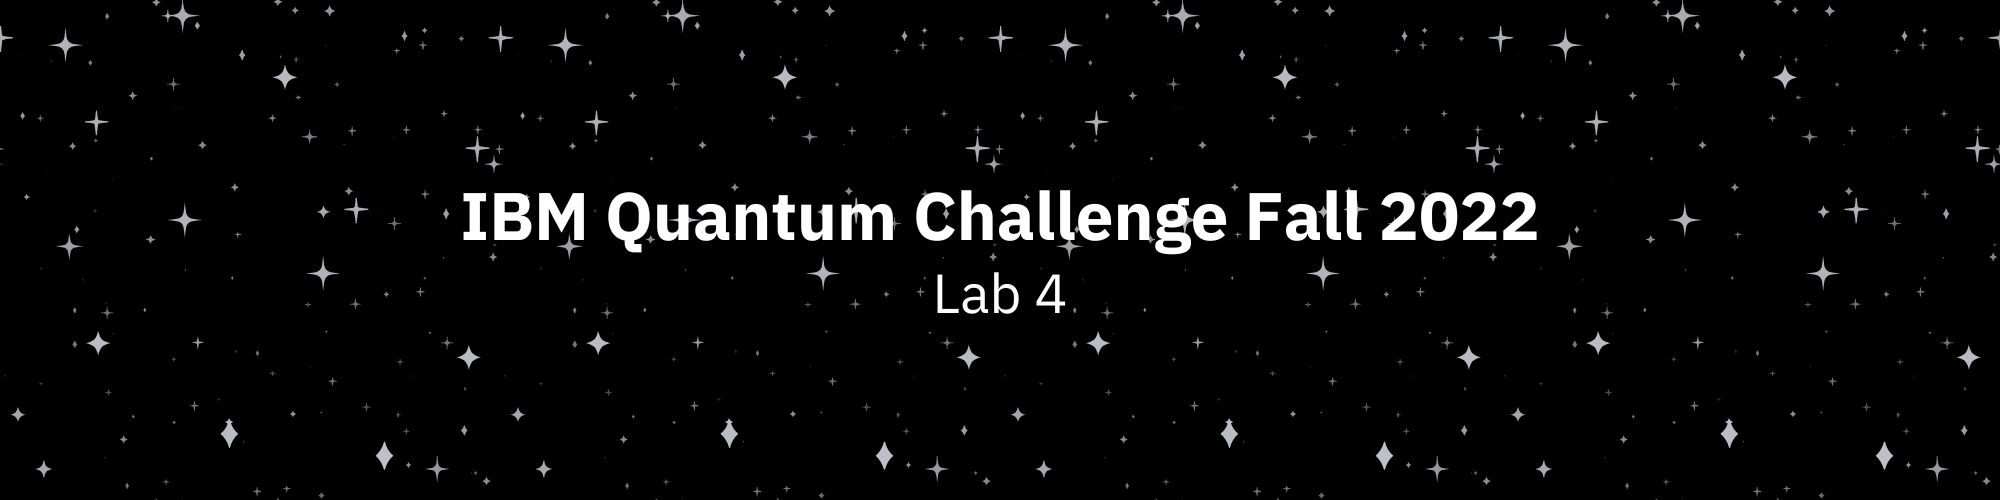

<div class="alert alert-block alert-success">
    <b>Final Ranked Exercise  </b><br/>
ここまでチャレンジを完了した皆さん、おめでとうございます! Final Exerciseまでとうとうたどり着きました! Exercise 5まで完了した時点でバッジ取得は確実なものになっています。この<b>最後のFinal Exerciseは、さらにハイスコアを狙い順位を競いたい方向け</b>に用意されています！ 

</div>

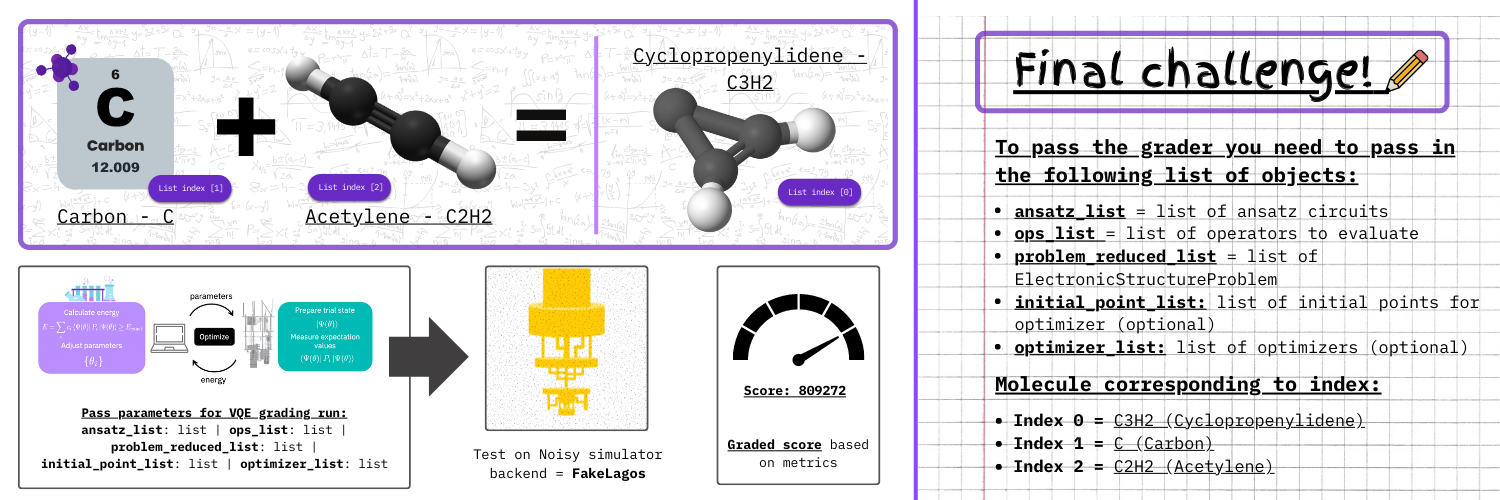

In [1]:
# Define geometry
carbon = [["C",[0.0,0.0,0.0]]]

# https://webbook.nist.gov/cgi/cbook.cgi?Name=acetylene&Units=SI
acetylene = [["C", [0.0000,    0.0000,   -0.6025]], 
            ["H",[    0.0000,    0.0000,   -1.6691]], 
            ["C",[    0.0000,    0.0000,    0.6025]], 
            ["H",[    0.0000,    0.0000,    1.6691]]]

# https://atct.anl.gov/Thermochemical%20Data/version%201.122/species/?species_number=442
Cyclopropenylidene =  [["C", [2.2883,    0.6993,    0.3468 ]],
           ["C",[    1.9543,    2.0133,    0.7806]],
           ["C",[    1.0108,    0.9522,    0.6802]],
           ["H",[    3.0291,    0.0000,    0.0000]],
           ["H",[    0.0000,    0.5997,    0.7904]]]

In [2]:
# Import necessary libraries and packages
import math
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from qiskit import Aer, IBMQ, QuantumCircuit, QuantumRegister
from qiskit.primitives import Estimator
from qiskit.providers.aer import StatevectorSimulator
from qiskit.utils import QuantumInstance

from qiskit.tools.jupyter import *
from qiskit.visualization import *

# Import Qiskit libraries for VQE
from qiskit.algorithms import MinimumEigensolverResult, VQE
from qiskit.algorithms.optimizers import SLSQP, SPSA, UMDA, COBYLA

# Import Qiskit Nature libraries
from qiskit_nature.algorithms import GroundStateEigensolver, VQEUCCFactory, VQEUVCCFactory,MinimumEigensolverFactory
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.circuit.library import UCC, UCCSD
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import ElectronicStructureDriverType, ElectronicStructureMoleculeDriver
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import BravyiKitaevMapper, JordanWignerMapper, ParityMapper
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.transformers.second_quantization.electronic import ActiveSpaceTransformer

# Prototype-zne
!pip install prototype-zne --quiet

from qiskit_nature.settings import settings

settings.dict_aux_operators = True

from qiskit.utils import algorithm_globals

from qiskit.algorithms.optimizers import SLSQP, SPSA, UMDA, COBYLA , L_BFGS_B

from qiskit_nature.circuit.library import UCC, UCCSD, UVCC, PUCCD, SUCCD, CHC, UVCCSD
from qiskit.circuit.library import TwoLocal
#https://qiskit.org/documentation/nature/apidocs/qiskit_nature.second_q.circuit.library.html#module-qiskit_nature.second_q.circuit.library

from qiskit.circuit.library import EfficientSU2, RealAmplitudes
from qiskit_nature.second_q.circuit.library import HartreeFock
from qiskit.compiler import transpile
from qiskit.providers.fake_provider import FakeLagos

In [3]:
def construct_problem(molecular_type,geometry, charge, multiplicity, basis, num_electrons, num_molecular_orbitals,bind_params):
    molecule = Molecule(geometry=geometry,charge=charge,multiplicity=multiplicity) 
    driver = ElectronicStructureMoleculeDriver(molecule, basis=basis, driver_type=ElectronicStructureDriverType.PYSCF) 
    #### basis
    
    
    # Run the preliminary quantum chemistry calculation
    properties = driver.run()

    # Set the active space
    active_space_trafo = ActiveSpaceTransformer(num_electrons=num_electrons,
                                        num_molecular_orbitals=num_molecular_orbitals)#,active_orbitals=range(num_molecular_orbitals)) 
    
    #trafo = freeze_core_trafo
    trafo = active_space_trafo
    
    # Now you can get the reduced electronic structure problem
    problem_reduced = ElectronicStructureProblem(driver, transformers=[trafo]) # ----------- Enter your code here

    # The second quantized Hamiltonian of the reduce problem
    second_q_ops_reduced = problem_reduced.second_q_ops()

    mapper_type = 'ParityMapper'
    #mapper_type = 'JordanWingerMapper'
    #mapper_type = 'BravyiKitaevMapper'
    
    #### mapper
    if mapper_type == 'ParityMapper':
        mapper = ParityMapper()
    elif mapper_type == 'JordanWignerMapper':
        mapper = JordanWignerMapper()
    elif mapper_type == 'BravyiKitaevMapper':
        mapper = BravyiKitaevMapper()


    parity_mapper = ParityMapper()
    # Set the mapper to qubits
    #parity_mapper = ParityMapper() # This is the example of parity mapping
    

    # Set the qubit converter with two qubit reduction to reduce the computational cost 
    print(molecular_type)
    if molecular_type == 'c':
        reduction = [-1,1,-1] #[-1,1,-1]
        parity_converter = QubitConverter(mapper,two_qubit_reduction=True,z2symmetry_reduction=reduction)
    elif molecular_type == 'ac':
        reduction = [1,1,1]#[1,1,1] # [1,1,1]
        parity_converter = QubitConverter(mapper,two_qubit_reduction=True,z2symmetry_reduction=reduction)
    elif molecular_type == 'cy':
        reduction = [1,1] # 'auto'
        parity_converter = QubitConverter(mapper,two_qubit_reduction=True,z2symmetry_reduction=reduction)
    else:
        reduction='auto'
        parity_converter = QubitConverter(mapper,two_qubit_reduction=True,z2symmetry_reduction="auto")
    #reduction = [-1,1,-1]
    
    # ----------- Enter your code here    

    # Compute the Hamitonian in qubit form
    qubit_op_parity = parity_converter.convert(second_q_ops_reduced.get('ElectronicEnergy'), num_particles=problem_reduced.num_particles)

    maxiter=500
    optimizer=COBYLA(maxiter=maxiter)#500
    
  
    #ansaztz
    ansatz_vqe = UCC(excitations='sd',qubit_converter=parity_converter)


    # Get reference solution
    vqe_factory = VQEUCCFactory(quantum_instance=StatevectorSimulator(),optimizer=optimizer,ansatz=ansatz_vqe) 

    solver = GroundStateEigensolver(parity_converter, vqe_factory)   
    solve_solution =solver.solve(problem_reduced)

    real_solution = solve_solution.total_energies[0]    
    
    #noisy_backend = FakeLagos()
    param_ansatz = vqe_factory.ansatz
    ansatz = transpile(param_ansatz.bind_parameters(bind_params),optimization_level=3,basis_gates=['cx','u3'])

   
    return ansatz, qubit_op_parity, real_solution, problem_reduced

In [ ]:
def custom_vqe(estimator, ansatz, ops, problem_reduced, optimizer = None, initial_point=None):

    # Define convergence list
    convergence = []

    # Keep track of jobs (Do-not-modify)
    job_list = []

    # Define evaluate_expectation function
    def evaluate_expectation(x):
        x = list(x)

        # Define estimator run parameters
        job =  estimator.run(ansatz,ops,x).result()# ----------- Enter your code here
        results = job.values[0]
        job_list.append(job)

        # Pass results back to callback function
        return np.real(results)

    # Call back function
    def callback(x,fx,ax,tx,nx):
        # Callback function to get a view on internal states and statistics of the optimizer for visualization
        convergence.append(evaluate_expectation(fx))

    np.random.seed(10)

    # Define initial point. We shall define a random point here based on the number of parameters in our ansatz
    if initial_point is None:
        initial_point = np.random.random(ansatz.num_parameters)

    # Define optimizer and pass callback function
    if optimizer == None:
        optimizer = SPSA(maxiter=50, callback=callback)

    # Define minimize function
    result = optimizer.minimize(evaluate_expectation,initial_point) # ----------- Enter your code here

    vqe_interpret = []
    for i in range(len(convergence)):
        sol = MinimumEigensolverResult()
        sol.eigenvalue = convergence[i]
        sol = problem_reduced.interpret(sol).total_energies[0]
        vqe_interpret.append(sol)

    return vqe_interpret, job_list, result

In [53]:
basis_array = ["ccpvtz-dk","ccpvtz-dk","sto6g"] # ["ccpvdz","ccpvdz","stp3g"] -> ["ccpvtz","ccpvtz","sto6g"] -> ["ccpvtz","ccpvtz-dk","sto6g"]
#initial_point_list = [[0.00084924, 0.03396582, 0.0082729 ],[0.1015217],[0.00078168, -0.0001025 ,  0.01655908, -0.03837969]]
initial_point_list = [[0.00084924, 0.03396582, 0.0082729 ],[0.1015217],[0, -0,  0, -0.497]]


ansatz_c, ops_c, real_solution_c,problem_reduced_c = construct_problem(molecular_type='c',geometry=carbon, charge=0, multiplicity=3, basis=basis_array[0], num_electrons=4, num_molecular_orbitals=4,bind_params=initial_point_list[1])

# Sample definition Acetylene
ansatz_ac, ops_ac, real_solution_ac, problem_reduced_ac = construct_problem(molecular_type='ac',geometry=acetylene, charge=0, multiplicity=1, basis=basis_array[1], num_electrons=4, num_molecular_orbitals=4,bind_params=initial_point_list[2])

# Sample defininition Cyclopropenylidene
ansatz_cy, ops_cy, real_solution_cy, problem_reduced_cy = construct_problem(molecular_type='cy',geometry=Cyclopropenylidene, charge=0, multiplicity=1, basis=basis_array[2], num_electrons=2, num_molecular_orbitals=2,bind_params=initial_point_list[0])

c
-4.478435830310497 * III
- 0.5660484142499222 * IIZ
+ 0.15737645333942266 * ZII
- 0.4402256577638993 * ZIZ
+ 0.04440980182934738 * XXX
- 0.04440980182934738 * YXY
+ 0.014617949632235198 * IXI
- 0.014617949632235198 * ZXZ
3
ac
-2.661592901930476 * III
+ 0.6772780459667191 * IIZ
+ 0.6772780459667296 * IZZ
- 0.027839098981140894 * ZZI
- 0.039030996558287886 * ZII
+ 0.5848419670232412 * IZI
+ 0.394532469256609 * ZZZ
+ 0.3945324692566008 * ZIZ
+ 0.009628743132788544 * IIX
- 0.009628743132788544 * IZX
+ 0.0017126245661306218 * IXX
+ 0.0017126245661306218 * ZYY
+ 0.0009702757107659052 * XXX
+ 0.0009702757107659052 * YXY
+ 0.0017126245661307025 * IXI
- 0.0017126245661307025 * ZXZ
+ 0.000970275710765927 * XXI
+ 0.000970275710765927 * YYZ
+ 0.05634483848310814 * XII
- 0.05634483848310814 * XZI
3
cy
-0.8033958426442681 * II
+ 0.22194485217632848 * IZ
- 1.4538021383999927e-07 * IX
- 0.22194485217632837 * ZI
- 1.4538021383999927e-07 * XI
- 0.10439554197546011 * ZZ
+ 1.5096815972881216e-07 * ZX
- 

<div class="alert alert-block alert-success">
    <b> ファイナルチャレンジ（任意）のスコアリングと提出方法について </b>

- VQE　grading runを成功させるために、以下を提出してください。ノイズの多いFakeBackend上で**3回のVQE実行**を行い、算出された結果を評価します。
  - `ansatz_list` = ansatz回路のリスト
  - `ops_list` = 評価する演算子のリスト
  - `problem_reduced_list` = ElectronicStructureProblemのリスト
  - `initial_point_list`: オプティマイザの初期点のリスト (こちらはオプショナルです。このリストを渡さない場合は初期点はランダムに取得されます。)
  - `optimizer_list`:  オプティマイザーのリスト (こちらはオプショナルです。このリストを渡さない場合はデフォルト`SPSA`に設定されます。)

- 提出されたリストの順序付きインデックス:
    - **Index 0** - $C_3H_2$ (Cyclopropenylidene)
    - **Index 1** - $C$ (Carbon)
    - **Index 2** - $C_2H_2$ (Acetylene)
    
- 基準値はクラシカルコンピューターで計算し、下記に掲載しました。<br>

- スコアは、**3つの要素**によって決定されます:
    - **Depth of ansatz**: なるべく低いコストの量子回路を構築してみましょう。スコアは以下のように計算されます。低ければ低いほど良いスコアです！ <br>
    $$スコア = 50 * depth + 10 * (\text{# of CX Gates}) + \text{# of Single Gates} $$

    - **Optimizer score**: Optimizerの iteration回数
    - **Reaction Energy**: 反応エネルギーの計算値に対する収束値の近さ（単位：eV)

- **なお、チャレンジ期間終了後、審査の結果、上位のスコアが変更される場合があります。**
  - 上位10名の参加者の方には、演習をどのように解いたか、レポートを提出していただきます。 <br>
    - 審査員は上位10作品を手動でチェックし、その解答がルールに則っているかどうかを確認します。<br>
    <br>
- **また、どなたでも課題終了後、課題レポに最終問題のご自身の回答をPRいただくことができます: [htps://github.com/qiskit-community/ibm-quantum-challenge-fall-22](https://github.com/qiskit-community/ibm-quantum-challenge-fall-22)**  チャレンジレポにPRを提出する際に、 `Name_Score_Fall22_Lab4.ipynb` のフォーマットでノートブックの名前を付けて提出をしてください。

</div>


<div class="alert alert-block alert-info">
    <b>基準値</b>
    
    
- Chemistry engine: Pyscf, version 2.0.1
- Python version: 3.9.12
- Computation options used: 
    - method: CCSD
    - basis: cc-pVDZ

    
**反応エネルギーの参考値: -4.26923078561136 eV**

</div>

In [54]:
ansatz_list = [ansatz_cy, ansatz_c, ansatz_ac] # List of ansatz circuits
ops_list = [ops_cy, ops_c, ops_ac] # List of operators
problem_reduced_list = [problem_reduced_cy,  problem_reduced_c,  problem_reduced_ac] # List of ElectronicStrucutreProblem

algorithm_globals.random_seed = 1
#initial_point_list = [np.random.random(ansatz_cy.num_parameters)*2*np.pi,np.random.random(ansatz_c.num_parameters)*2*np.pi,np.random.random(ansatz_ac.num_parameters)*2*np.pi]
#initial_point_list = [np.zeros(ansatz_cy.num_parameters),np.zeros(ansatz_c.num_parameters),np.zeros(ansatz_ac.num_parameters)]
#initial_point_list = [[-0.00773758,  0.05787027,  0.03328942],[0.12109375],[ 0.00869987, -0.01897677, -0.01526445,  0.01852335]]
#initial_point_list = [[-6.27809217,  3.14144005, -9.41322048],[0.10629421],[ 1.16004653, 53.39715989, 31.51406428,  4.14839848]]
#initial_point_list = [[0.00084924, 0.03396582, 0.0082729 ],[0.1015217],[0.00078168, -0.0001025 ,  0.01655908, -0.03837969]]
initial_point_list = [[],[],[]]
maxiter=1

optimizer_list = [COBYLA(maxiter=maxiter),COBYLA(maxiter=maxiter),COBYLA(maxiter=maxiter)]


[[], [], []]


In [55]:
## Grade and submit your solution
from qc_grader.challenges.fall_2022 import grade_lab4_final

#grade_lab4_final(ansatz_list, ops_list, problem_reduced_list)
#grade_lab4_final(ansatz_list, ops_list, problem_reduced_list, initial_point_list)
# Optional - grade_lab4_final(ansatz_list, ops_list, problem_reduced_list, optimizer_list)
# Optional - grade_lab4_final(ansatz_list, ops_list, problem_reduced_list, initial_point_list, optimizer_list)
grade_lab4_final(ansatz_list, ops_list, problem_reduced_list, initial_point_list, optimizer_list)
# Optional prototype-zne - grade_lab4_final(ansatz_list, ops_list, problem_reduced_list, initial_point_list, optimizer_list, zne_strategy)
#grade_lab4_final(ansatz_list, ops_list, problem_reduced_list, initial_point_list, optimizer_list, zne_strategy)

Running VQE....... 1
VQE run 1 complete
Converged value for run 1 is: (-114.2807137306171+0j)
Result for run 1: {   'fun': -1.1301803786959819,
    'jac': None,
    'nfev': 1,
    'nit': None,
    'njev': None,
    'x': array([], dtype=float64)} 

Running VQE....... 2
VQE run 2 complete
Converged value for run 2 is: (-37.61461093004361+0j)
Result for run 2: {   'fun': -5.2561159521915455,
    'jac': None,
    'nfev': 1,
    'nit': None,
    'njev': None,
    'x': array([], dtype=float64)} 

Running VQE....... 3
VQE run 3 complete
Converged value for run 3 is: (-76.50859560328445+0j)
Result for run 3: {   'fun': -3.948448460651568,
    'jac': None,
    'nfev': 1,
    'nit': None,
    'njev': None,
    'x': array([], dtype=float64)} 

Submitting your answer. Please wait...

Your computed reaction energy: -4.286022849750322 eV

Your total score is 78600

Congratulations 🎉! Your answer is correct.

